In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
#import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
from selenium import webdriver
from datetime import datetime

#dates of the html pages
d_path = "data/html"
save_path = "data/dates.txt"

if not os.path.exists(save_path):
    data_dict=dict()

    with open(save_path, 'w') as f:
        f.write("id date\n")

        driver=webdriver.Chrome()

        if os.path.exists(d_path):
            for file in os.listdir(d_path):
                full_path = os.path.join(d_path, file)

                try:#stupid DS_Store file >:/ 

                    #open the file in the browser
                    driver.get('file://' + os.path.abspath(full_path))
                    html_source = driver.page_source
                    soup=BeautifulSoup(html_source, 'html.parser')
                    date=soup.find('div',{'class':'pt-3 text-base text-gray-400 sm:pt-4'}).text
                    
                    #if date is in format NAME•Month Day, Year
                    if '•' in date:
                        date=date.split('•')[1]
                        
                    date=datetime.strptime(date, '%B %d, %Y').date()
                    id=file.split('.')[0]

                    #to avoid running selenium every time, save the dates to a file
                    if date is not None and id is not None:
                        f.write(" ".join([id, str(date)]) + '\n')
                    data_dict[id]=date
                    
                except:
                    pass


        driver.close()

#to save time, load the dates from the file
if os.path.exists(save_path):
    df_dates = pd.read_csv(save_path, delim_whitespace=True)
    df_dates.dropna(inplace=True)
    data_dict= dict(zip(df_dates['id'], df_dates['date']))

    #make the date values a datetime object in the dict as the rest of the code expects it    
    for key in data_dict:
        data_dict[key]=datetime.strptime(data_dict[key], '%Y-%m-%d').date()
           
            

/Users/kaanguraysirin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
data_dict

{'b73f91f8-732f-4a48-bcbd-eadbbb457a94': datetime.date(2023, 11, 25),
 '746b8f06-1e89-43b8-b73c-1121eecfc854': datetime.date(2023, 11, 15),
 '30283b91-7fc3-4125-985b-b441f0f489d6': datetime.date(2023, 11, 26),
 'ef5b3fbc-f5d2-4446-bb4f-7d8b2a3026e9': datetime.date(2023, 11, 22),
 '106ffe99-c787-4d09-9076-4ba411eb68b1': datetime.date(2023, 11, 25),
 '65ea56c3-e205-4ed9-8b85-bd1876228cee': datetime.date(2023, 11, 26),
 '0c95c563-f1e1-4a35-844c-2e8ccdd1b161': datetime.date(2023, 11, 26),
 '22bb7162-3399-464a-b30b-cf1fc3210b4e': datetime.date(2023, 11, 19),
 'ba18e4e8-2c26-46d4-ba31-cc21947aabd5': datetime.date(2023, 11, 15),
 '2446216c-c557-4ee8-b470-7e2ae3c88968': datetime.date(2023, 11, 26),
 '8a84e6e5-d200-4cc2-a288-5c81201100c7': datetime.date(2023, 11, 26),
 'a948a3e5-70e5-447a-b3b4-baf3661f7b7e': datetime.date(2023, 11, 17),
 'ebe86296-3cae-429a-9a7c-aa8f21cfd7cb': datetime.date(2023, 11, 26),
 '26d95379-e2f1-454c-a9d2-60cd80bc06a5': datetime.date(2023, 11, 26),
 '7c734c12-e18b-4de8

In [4]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="utf-8") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]
        
        # read the html file
        html_page = fh.read()
       
        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})


        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:06<00:00, 18.79it/s]


In [5]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][5])

{'role': 'assistant',
 'text': 'To preprocess the dataset as per your requirements, you can follow '
         'these steps:Check for missing values and handle them.Encode labels '
         'with mappings using the map function.Split the data into training '
         "(80%) and testing (20%) sets.Here's the Python code to achieve "
         'this:pythonCopy codeimport pandas as pd\n'
         'from sklearn.model_selection import train_test_split\n'
         '\n'
         '# Load the dataset into a Pandas DataFrame\n'
         "file_path = 'cs412_hw1_dataset.csv'\n"
         'df = pd.read_csv(file_path)\n'
         '\n'
         '# 1. Check for missing values and handle them\n'
         '# You can either drop rows with missing values or fill them with the '
         'most common value in the column.\n'
         "# In this example, we'll fill missing values with the most common "
         'value in each column.\n'
         '\n'
         "# Fill missing values in the 'Sex' column with the 

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [6]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [7]:
code2prompts["0031c86e-81f4-4eef-9e0e-28037abf9883"][2]

"You will preprocess the data now\n1. Check for missing values and handle them by either dropping or filling them with the most common values. Ensure that there is enough data for training the model. You can only use %80 data for training and %20 for testing\n2. Encode labels with mappings using the map function. Mapping names: \n   - sex_map = {'female': 1, 'male': 0}\n   - island_map = {'Biscoe': 1, 'Dream': 2, 'Torgensen': 3}\n   - diet_map = {'fish': 1, 'krill': 2, 'squid': 3, 'parental': 4}\n   - life_stage_map = {'chick': 1, 'juvenile': 2, 'adult': 3}\n   - health_metrics_map = {'healthy': 1, 'overweight': 2, 'underweight': 3}\nThe dataset named 'df'."

In [8]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [9]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [10]:
vectorizer

TfidfVectorizer()

In [11]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,ödevimiz,önerin,ın,ınfo,şimdi,şunlar,şöyle,şıkkı,şıkkını,şıklarını
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [13]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,ödevimiz,önerin,ın,ınfo,şimdi,şunlar,şöyle,şıkkı,şıkkını,şıklarını
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
code2prompts_tf_idf['ef5b3fbc-f5d2-4446-bb4f-7d8b2a3026e9'].shape

(100, 5365)

In [15]:
#not used
#find the longest conversation
max_shape = 0
max_code = ""
for code, prompts in code2prompts_tf_idf.items():
    if prompts.shape[0] > max_shape:
        max_shape = prompts.shape[0]
        max_code = code

print(max_code, max_shape)

ef5b3fbc-f5d2-4446-bb4f-7d8b2a3026e9 100


In [16]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [17]:
# how many times the user asked each question
question_count= dict()

for key in code2cosine.keys():
    #try keeping them in a np array
    q_count= np.zeros(9)
    for idx, row in code2cosine[key].T.iterrows():
        q_count[row.idxmax()] += 1
    ##softmax    
    #total = sum(q_count)
    #q_count = [q/total for q in q_count]
    question_count[key] = q_count


In [18]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [19]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153582,0.294878,0.522162,0.352245,0.460602,0.553879,0.167269,0.182931,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192067,0.795607,0.772174,0.882656,0.607118,0.987511,0.892586,0.570733,0.544886
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258378,0.295922,0.624850,0.351870,0.643034,0.454330,0.540284,0.546518,0.325791
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.146064,0.117834,0.267381,0.316809,0.333889,0.314856,0.192434,0.261892,0.407266
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344280,0.575528,0.782873,0.624833,0.724877,0.872171,0.684798,0.945305,0.512563
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187470,0.209888,0.358883,0.211246,0.149289,0.507131,1.000000,0.862585,0.739741
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144801,0.139495,0.332274,0.950344,0.775707,0.828352,0.374145,0.905688,0.553340
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211060,0.908697,0.977726,0.924311,0.888609,0.921307,0.779558,0.767328,0.500298
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173262,0.967321,1.000000,0.703984,0.942662,0.907415,1.000000,1.000000,0.783783


In [20]:
code2questionmapping

{'0031c86e-81f4-4eef-9e0e-28037abf9883': [0.15358153691486517,
  0.29487767975965445,
  0.5221621262482337,
  0.35224542227547595,
  0.4606020230208219,
  0.5538790829950878,
  0.16726857281316698,
  0.1829307596879451,
  0.19543980723403126],
 '0225686d-b825-4cac-8691-3a3a5343df2b': [0.19206674508439306,
  0.7956070017414438,
  0.7721735356211749,
  0.882656373142389,
  0.6071183388189029,
  0.987511272043265,
  0.8925855395394181,
  0.5707328987047433,
  0.5448861987096727],
 '041f950b-c013-409a-a642-cffff60b9d4b': [0.2583781312188402,
  0.29592162716335885,
  0.6248498601012044,
  0.3518704585117849,
  0.643033872054225,
  0.45432995357199907,
  0.5402844257509843,
  0.5465183653530945,
  0.3257914087551935],
 '04f91058-d0f8-4324-83b2-19c671f433dc': [0.14606384468163275,
  0.1178341877511933,
  0.2673807090107631,
  0.3168090161107947,
  0.3338888734847607,
  0.3148563623515387,
  0.19243431969449235,
  0.2618923912956749,
  0.40726551950097484],
 '089eb66d-4c3a-4f58-b98f-a3774a2efb

# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [101]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "help", "also", "explain"]
keywords2search = [k.lower() for k in keywords2search]

keywords2searchResponses=["python", "copy code", "import"]
keywords2searchResponses = [k.lower() for k in keywords2searchResponses]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)
            for kw in keywords2searchResponses:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"{kw}", text))

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["total_avg_chars"] = code2features[code]["prompt_avg_chars"] + code2features[code]["response_avg_chars"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [102]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#help,#also,#explain,prompt_avg_chars,response_avg_chars,total_avg_chars,#python,#copy code,#import
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,4.0,2.0,2.205748,212.206370,214.412118,23.0,14.0,34.0
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.304163,113.617969,113.922131,27.0,22.0,18.0
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.262324,17.187601,17.449926,18.0,19.0,9.0
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.123346,107.092566,107.215911,24.0,23.0,57.0
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.017986,18.850913,18.868899,102.0,101.0,93.0


In [103]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


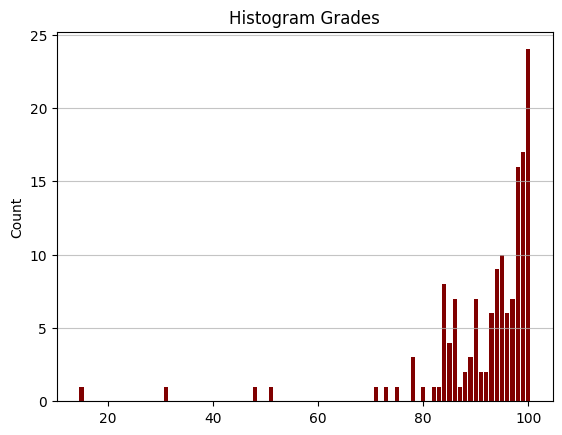

In [129]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5, color="maroon")
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Count')
plt.show()

In [105]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#help,#also,#explain,prompt_avg_chars,response_avg_chars,total_avg_chars,#python,#copy code,#import
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,4.0,2.0,2.205748,212.206370,214.412118,23.0,14.0,34.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.304163,113.617969,113.922131,27.0,22.0,18.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.262324,17.187601,17.449926,18.0,19.0,9.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.123346,107.092566,107.215911,24.0,23.0,57.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.017986,18.850913,18.868899,102.0,101.0,93.0


In [106]:
#convert id_date to dataframe make the columns code and date
id_date_df=pd.DataFrame(list(data_dict.items()),columns=['code','date'])

#encode the datetime object into ordinal
id_date_df['date']=id_date_df['date'].apply(lambda x: x.toordinal())
id_date_df.head()

#merge the dataframes
df=pd.merge(df, id_date_df, on='code', how='left')


In [107]:
df_dates.shape

(123, 2)

In [108]:
#makes it worse

#merge with the question counts
question_count_df=pd.DataFrame(list(question_count.items()),columns=['code','question_count'])
question_count_df=pd.concat([question_count_df.drop(['question_count'], axis=1), question_count_df['question_count'].apply(pd.Series)], axis=1)

question_count_df.columns=['code']+['#Q'+str(i) for i in range(9)]

#df=pd.merge(df, question_count_df, on='code', how='left')


In [109]:
question_count_df.head()

,code,#Q0,#Q1,#Q2,#Q3,#Q4,#Q5,#Q6,#Q7,#Q8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,1.0,1.0,2.0,3.0,6.0,1.0,0.0,0.0,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.0,1.0,5.0,1.0,4.0,2.0,1.0,3.0,1.0
2,041f950b-c013-409a-a642-cffff60b9d4b,0.0,0.0,2.0,3.0,1.0,0.0,2.0,1.0,0.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.0,0.0,6.0,3.0,6.0,1.0,1.0,2.0,1.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,5.0,1.0,19.0,15.0,17.0,9.0,7.0,4.0,9.0


In [110]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#help,#also,#explain,prompt_avg_chars,...,date,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,4.0,2.0,2.205748,...,738850,0.153582,0.294878,0.522162,0.352245,0.460602,0.553879,0.167269,0.182931,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.304163,...,738850,0.192067,0.795607,0.772174,0.882656,0.607118,0.987511,0.892586,0.570733,0.544886
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.262324,...,738850,0.258378,0.295922,0.624850,0.351870,0.643034,0.454330,0.540284,0.546518,0.325791
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.123346,...,738834,0.146064,0.117834,0.267381,0.316809,0.333889,0.314856,0.192434,0.261892,0.407266
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.017986,...,738850,0.344280,0.575528,0.782873,0.624833,0.724877,0.872171,0.684798,0.945305,0.512563


#### Merging scores with features

In [111]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#help,#also,#explain,prompt_avg_chars,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,4.0,2.0,2.205748,...,0.153582,0.294878,0.522162,0.352245,0.460602,0.553879,0.167269,0.182931,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.304163,...,0.192067,0.795607,0.772174,0.882656,0.607118,0.987511,0.892586,0.570733,0.544886,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.262324,...,0.258378,0.295922,0.624850,0.351870,0.643034,0.454330,0.540284,0.546518,0.325791,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.123346,...,0.146064,0.117834,0.267381,0.316809,0.333889,0.314856,0.192434,0.261892,0.407266,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.017986,...,0.344280,0.575528,0.782873,0.624833,0.724877,0.872171,0.684798,0.945305,0.512563,100.0


In [112]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 24) (122,)


#### Train/Test split

In [123]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
#X_train, y_train = ros.fit_resample(X_train, y_train)


print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [124]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import VotingRegressor

from sklearn.metrics import mean_absolute_error, explained_variance_score

#clf1 = GradientBoostingRegressor(random_state=0,criterion='squared_error', learning_rate=0.25)
#clf2 = RandomForestRegressor(random_state=0, max_depth=5, criterion='squared_error', max_features='log2')
#clf3 = AdaBoostRegressor(random_state=0)

#grd1 = GradientBoostingRegressor(random_state=0,loss='squared_error', learning_rate=0.1, n_estimators=48)
#grd2 = GradientBoostingRegressor(random_state=0,criterion='squared_error', learning_rate=0.2, n_estimators=49)
grd3 = GradientBoostingRegressor(random_state=0,criterion='squared_error', learning_rate=0.25, n_estimators=49)

#eclf= VotingRegressor(estimators=[('gb', clf1), ('rf', clf2), ("ab",clf3)])
#eclfgrad= VotingRegressor(estimators=[('gb', grd1), ('rf', grd2), ("ab",grd3)])

#for clf, label in zip([grd1,grd2,grd3, eclfgrad],["GradBoost0.1","GradBoost0.2","GradBoost0.25","Ensemble"]):
#    clf.fit(X_train, y_train)
#    print("Model: ", label)
#    print("MSE Train:\t", mean_squared_error(y_train, clf.predict(X_train)))
#    print("MSE Test:\t", mean_squared_error(y_test, clf.predict(X_test)))
#    print("R2 Train:\t", r2_score(y_train, clf.predict(X_train)))
#    print("R2 Test:\t", r2_score(y_test, clf.predict(X_test)))   
#    print("====================================")



In [126]:
# Prediction
grd3.fit(X_train, y_train)

y_train_pred = grd3.predict(X_train)
y_test_pred = grd3.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 0.32803233410749866
MSE TEST: 48.27201989971048
R2 Train: 0.9979927080702425
R2 TEST: 0.5700194903896609
